In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

print("📊 Libraries imported successfully!")

📊 Libraries imported successfully!


In [3]:
import os
# Check what files are in the data/raw directory
os.chdir("C:/Users/Inchara/SHOPPER-SPECTRUM")
# Load cleaned transaction data
df = pd.read_csv('data/processed/cleaned_ecommerce_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("=== TRANSACTION DATA LOADED ===")
print(f"Shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique products: {df['StockCode'].nunique()}")

# Preview data
df.head()

=== TRANSACTION DATA LOADED ===
Shape: (392692, 16)
Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00
Unique customers: 4338
Unique products: 3665


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month,Day,DayOfWeek,DayName,Hour,DaysSinceLatest
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2022,12,1,3,Thursday,8,373
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2022,12,1,3,Thursday,8,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2022,12,1,3,Thursday,8,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2022,12,1,3,Thursday,8,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2022,12,1,3,Thursday,8,373


=== 1. DATA PREPARATION ===
Customer-Product interactions: 268398
Unique customers: 4338
Unique products: 3665

Top 10 products by customer count:
     StockCode                         Description  Customer_Count  \
1318     22423            REGENCY CAKESTAND 3 TIER             881   
3459    85123A  WHITE HANGING HEART T-LIGHT HOLDER             856   
2799     47566                       PARTY BUNTING             708   
3278     84879       ASSORTED COLOUR BIRD ORNAMENT             678   
1607     22720   SET OF 3 CAKE TINS PANTRY DESIGN              640   
432      21212     PACK OF 72 RETROSPOT CAKE CASES             635   
3444    85099B             JUMBO BAG RED RETROSPOT             635   
1001     22086     PAPER CHAIN KIT 50'S CHRISTMAS              613   
1351     22457     NATURAL SLATE HEART CHALKBOARD              587   
1054     22138       BAKING SET 9 PIECE RETROSPOT              581   

      Total_Quantity_Sold  Total_Revenue  
1318                12374      142264.7

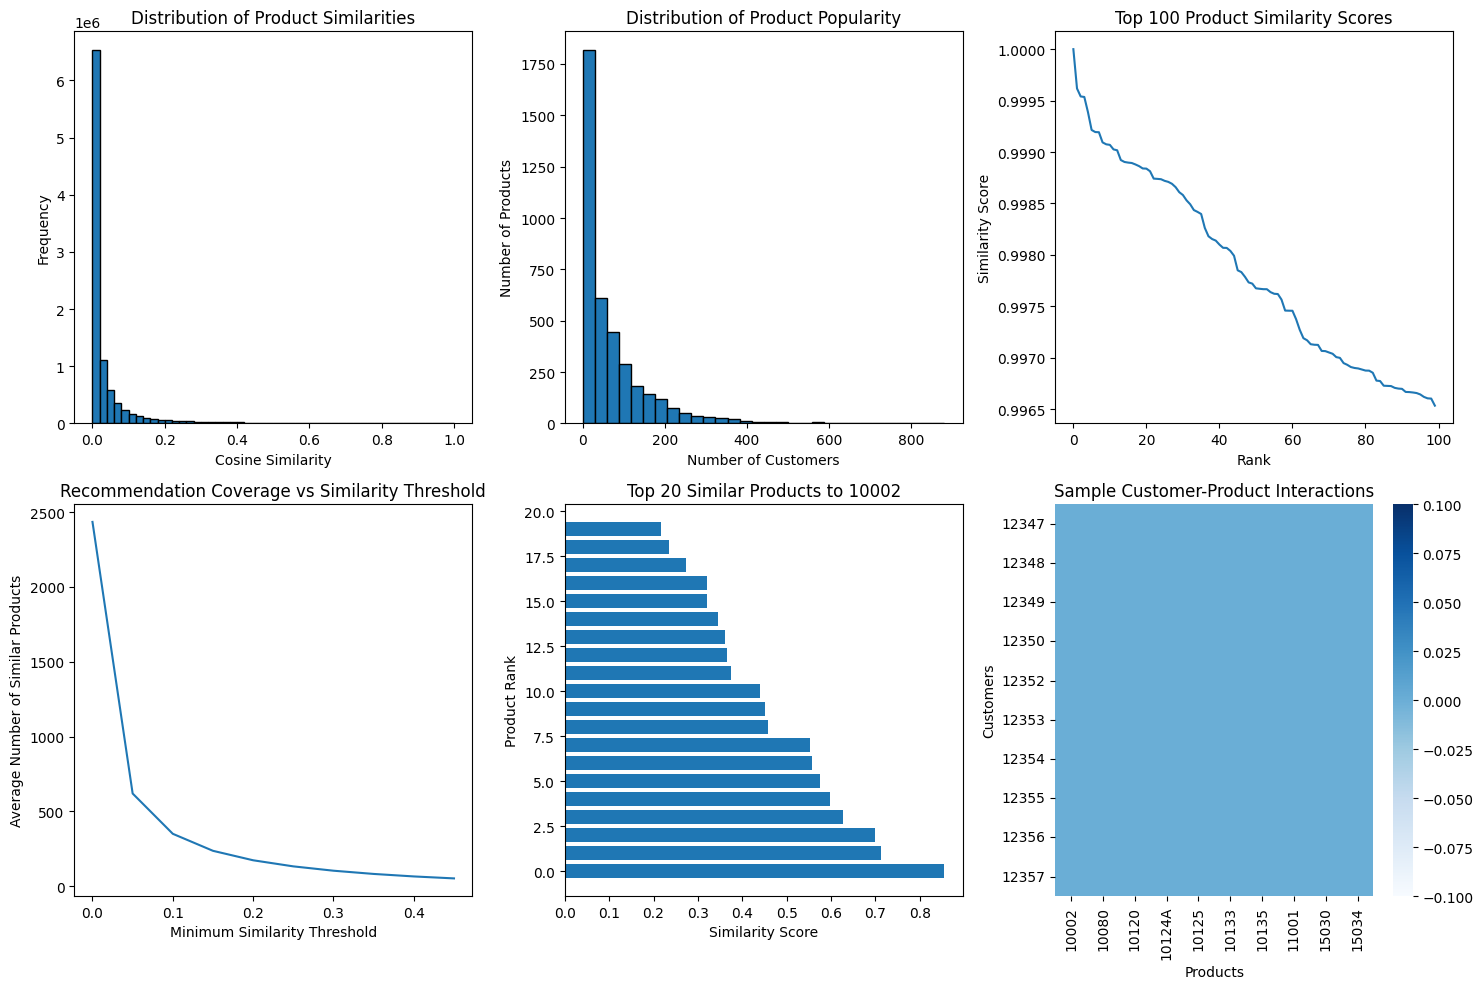


=== 8. RECOMMENDATION SYSTEM EVALUATION ===
📊 RECOMMENDATION SYSTEM EVALUATION:
• Coverage: 80.9% (3151 out of 3897 products)
• Diversity: 0.494 (higher = more diverse)
• Popularity Bias: 0.99 (1.0 = no bias)

💡 SYSTEM INSIGHTS:
• Good balance between coverage, diversity, and popularity

=== 9. CREATING LOOKUP TABLES ===
Creating recommendation lookup tables...
Pre-computed recommendations for 3151 products
Created name mapping for 3877 products
Selected 20 popular products for fallbacks

=== 10. SAVING RECOMMENDATION MODEL ===
Saving similarity matrix...
Saving recommendation lookup tables...
Saving product information...
Saving customer-product matrix...
✅ Recommendation system saved:
• models/product_similarity_matrix.pkl - Product similarity matrix
• models/product_recommendations.pkl - Pre-computed recommendations
• models/product_name_mapping.pkl - Product name to code mapping
• models/popular_products.pkl - Popular products for fallbacks
• models/recommendation_metadata.pkl - S

In [4]:
# 1. DATA PREPARATION FOR RECOMMENDATION SYSTEM
print("=== 1. DATA PREPARATION ===")

# Create aggregated customer-product interaction data
# Sum quantities for each customer-product combination
interaction_data = df.groupby(['CustomerID', 'StockCode', 'Description']).agg({
    'Quantity': 'sum',
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique'  # Number of times purchased
}).reset_index()

interaction_data.columns = ['CustomerID', 'StockCode', 'Description', 'Total_Quantity', 'Total_Amount', 'Purchase_Frequency']

print(f"Customer-Product interactions: {len(interaction_data)}")
print(f"Unique customers: {interaction_data['CustomerID'].nunique()}")
print(f"Unique products: {interaction_data['StockCode'].nunique()}")

# Product statistics for filtering
product_stats = interaction_data.groupby(['StockCode', 'Description']).agg({
    'CustomerID': 'nunique',  # Number of customers who bought this product
    'Total_Quantity': 'sum',
    'Total_Amount': 'sum'
}).reset_index()

product_stats.columns = ['StockCode', 'Description', 'Customer_Count', 'Total_Quantity_Sold', 'Total_Revenue']
product_stats = product_stats.sort_values('Customer_Count', ascending=False)

print(f"\nTop 10 products by customer count:")
print(product_stats.head(10))

# %%
# 2. FILTER PRODUCTS FOR RECOMMENDATION SYSTEM
print("\n=== 2. PRODUCT FILTERING ===")

# Filter products that have been purchased by at least N customers
min_customers = 5  # Minimum number of customers who must have bought the product
popular_products = product_stats[product_stats['Customer_Count'] >= min_customers]['StockCode'].tolist()

# Filter customers who have purchased at least N products
min_products = 3  # Minimum number of different products a customer must have bought
active_customers = interaction_data.groupby('CustomerID')['StockCode'].nunique()
active_customers = active_customers[active_customers >= min_products].index.tolist()

print(f"Products with at least {min_customers} customers: {len(popular_products)}")
print(f"Customers with at least {min_products} products: {len(active_customers)}")

# Filter interaction data
filtered_interactions = interaction_data[
    (interaction_data['StockCode'].isin(popular_products)) &
    (interaction_data['CustomerID'].isin(active_customers))
]

print(f"Filtered interactions: {len(filtered_interactions)}")
print(f"Data sparsity: {len(filtered_interactions) / (len(active_customers) * len(popular_products)) * 100:.2f}%")

# %%
# 3. CREATE CUSTOMER-PRODUCT MATRIX
print("\n=== 3. CUSTOMER-PRODUCT MATRIX ===")

# Create pivot table (customer-product matrix)
# Use quantity as the interaction strength
customer_product_matrix = filtered_interactions.pivot_table(
    index='CustomerID',
    columns='StockCode', 
    values='Total_Quantity',
    fill_value=0
)

print(f"Matrix shape: {customer_product_matrix.shape}")
print(f"Matrix density: {(customer_product_matrix > 0).sum().sum() / (customer_product_matrix.shape[0] * customer_product_matrix.shape[1]) * 100:.2f}%")

# Display sample of the matrix
print(f"\nSample of customer-product matrix:")
print(customer_product_matrix.iloc[:5, :5])

# %%
# 4. CALCULATE PRODUCT SIMILARITY MATRIX
print("\n=== 4. PRODUCT SIMILARITY CALCULATION ===")

# Transpose matrix to get product-customer matrix for item-based filtering
product_customer_matrix = customer_product_matrix.T

print(f"Product-customer matrix shape: {product_customer_matrix.shape}")

# Calculate cosine similarity between products
print("Calculating cosine similarity... (this may take a moment)")
product_similarity = cosine_similarity(product_customer_matrix)

# Convert to DataFrame for easier handling
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=product_customer_matrix.index,
    columns=product_customer_matrix.index
)

print(f"Product similarity matrix shape: {product_similarity_df.shape}")

# Display sample similarities
print(f"\nSample product similarities:")
sample_product = product_similarity_df.index[0]
print(f"Products similar to {sample_product}:")
similar_products = product_similarity_df[sample_product].sort_values(ascending=False)[1:6]  # Exclude self
for product, similarity in similar_products.items():
    product_name = product_stats[product_stats['StockCode'] == product]['Description'].iloc[0]
    print(f"  {product}: {product_name[:50]} (similarity: {similarity:.3f})")

# %%
# 5. BUILD RECOMMENDATION FUNCTIONS
print("\n=== 5. RECOMMENDATION FUNCTIONS ===")

def get_product_recommendations(product_code, similarity_matrix, product_info, n_recommendations=5):
    """
    Get product recommendations based on item similarity
    
    Args:
        product_code: StockCode of the product
        similarity_matrix: Product similarity matrix
        product_info: DataFrame with product information
        n_recommendations: Number of recommendations to return
    
    Returns:
        List of recommended products with similarity scores
    """
    if product_code not in similarity_matrix.index:
        return f"Product {product_code} not found in similarity matrix"
    
    # Get similarity scores for the product
    similarities = similarity_matrix[product_code].sort_values(ascending=False)
    
    # Exclude the product itself and get top N
    recommendations = similarities[1:n_recommendations+1]
    
    # Get product details
    rec_details = []
    for stock_code, similarity_score in recommendations.items():
        product_row = product_info[product_info['StockCode'] == stock_code]
        if not product_row.empty:
            rec_details.append({
                'StockCode': stock_code,
                'Description': product_row['Description'].iloc[0],
                'Similarity_Score': similarity_score,
                'Customer_Count': product_row['Customer_Count'].iloc[0],
                'Total_Revenue': product_row['Total_Revenue'].iloc[0]
            })
    
    return rec_details

def get_customer_recommendations(customer_id, customer_product_matrix, similarity_matrix, product_info, n_recommendations=5):
    """
    Get product recommendations for a specific customer
    
    Args:
        customer_id: ID of the customer
        customer_product_matrix: Customer-product interaction matrix
        similarity_matrix: Product similarity matrix
        product_info: DataFrame with product information
        n_recommendations: Number of recommendations to return
    
    Returns:
        List of recommended products for the customer
    """
    if customer_id not in customer_product_matrix.index:
        return f"Customer {customer_id} not found"
    
    # Get products the customer has already purchased
    customer_products = customer_product_matrix.loc[customer_id]
    purchased_products = customer_products[customer_products > 0].index.tolist()
    
    if not purchased_products:
        return "Customer has no purchase history"
    
    # Calculate recommendation scores for all products
    recommendation_scores = {}
    
    for product in similarity_matrix.index:
        if product not in purchased_products:  # Don't recommend already purchased products
            score = 0
            for purchased_product in purchased_products:
                if purchased_product in similarity_matrix.index:
                    # Weight by customer's interaction with the purchased product
                    interaction_weight = customer_products[purchased_product]
                    product_similarity = similarity_matrix.loc[purchased_product, product]
                    score += interaction_weight * product_similarity
            
            recommendation_scores[product] = score
    
    # Sort by score and get top N
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    top_recommendations = sorted_recommendations[:n_recommendations]
    
    # Get product details
    rec_details = []
    for stock_code, score in top_recommendations:
        product_row = product_info[product_info['StockCode'] == stock_code]
        if not product_row.empty:
            rec_details.append({
                'StockCode': stock_code,
                'Description': product_row['Description'].iloc[0],
                'Recommendation_Score': score,
                'Customer_Count': product_row['Customer_Count'].iloc[0],
                'Total_Revenue': product_row['Total_Revenue'].iloc[0]
            })
    
    return rec_details

def search_product_by_name(search_term, product_info):
    """
    Search for products by name/description
    
    Args:
        search_term: Search string
        product_info: DataFrame with product information
    
    Returns:
        List of matching products
    """
    matches = product_info[product_info['Description'].str.contains(search_term, case=False, na=False)]
    return matches[['StockCode', 'Description', 'Customer_Count', 'Total_Revenue']].head(10)

print("✅ Recommendation functions created!")

# %%
# 6. TEST RECOMMENDATION SYSTEM
print("\n=== 6. TESTING RECOMMENDATION SYSTEM ===")

# Test 1: Product-based recommendations
print("TEST 1: Product-based recommendations")
test_product = popular_products[0]  # Use first popular product
test_product_name = product_stats[product_stats['StockCode'] == test_product]['Description'].iloc[0]

print(f"\nGetting recommendations for: {test_product} - {test_product_name}")
product_recs = get_product_recommendations(test_product, product_similarity_df, product_stats, n_recommendations=5)

if isinstance(product_recs, list):
    print("Recommended products:")
    for i, rec in enumerate(product_recs, 1):
        print(f"{i}. {rec['StockCode']}: {rec['Description'][:50]} (Similarity: {rec['Similarity_Score']:.3f})")
else:
    print(product_recs)

# Test 2: Customer-based recommendations
print(f"\nTEST 2: Customer-based recommendations")
test_customer = active_customers[0]  # Use first active customer

print(f"\nGetting recommendations for Customer ID: {test_customer}")
# Show customer's purchase history first
customer_history = filtered_interactions[filtered_interactions['CustomerID'] == test_customer]
print(f"Customer's purchase history ({len(customer_history)} products):")
for _, row in customer_history.head().iterrows():
    print(f"  - {row['StockCode']}: {row['Description'][:50]} (Qty: {row['Total_Quantity']})")

customer_recs = get_customer_recommendations(test_customer, customer_product_matrix, product_similarity_df, product_stats, n_recommendations=5)

if isinstance(customer_recs, list):
    print("\nRecommended products:")
    for i, rec in enumerate(customer_recs, 1):
        print(f"{i}. {rec['StockCode']}: {rec['Description'][:50]} (Score: {rec['Recommendation_Score']:.2f})")
else:
    print(customer_recs)

# Test 3: Product search
print(f"\nTEST 3: Product search functionality")
search_results = search_product_by_name("WHITE", product_stats)
print("Products containing 'WHITE':")
print(search_results)

# %%
# 7. RECOMMENDATION QUALITY ANALYSIS
print("\n=== 7. RECOMMENDATION QUALITY ANALYSIS ===")

# Analyze similarity distribution
similarity_values = product_similarity_df.values
similarity_values = similarity_values[similarity_values != 1.0]  # Exclude self-similarity

print(f"Similarity Statistics:")
print(f"Mean similarity: {similarity_values.mean():.3f}")
print(f"Std similarity: {similarity_values.std():.3f}")
print(f"Min similarity: {similarity_values.min():.3f}")
print(f"Max similarity: {similarity_values.max():.3f}")

# Plot similarity distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(similarity_values, bins=50, edgecolor='black')
plt.title('Distribution of Product Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Analyze recommendation diversity
plt.subplot(2, 3, 2)
customer_counts = product_stats['Customer_Count']
plt.hist(customer_counts, bins=30, edgecolor='black')
plt.title('Distribution of Product Popularity')
plt.xlabel('Number of Customers')
plt.ylabel('Number of Products')

# Top similar product pairs
plt.subplot(2, 3, 3)
similarity_upper = np.triu(product_similarity_df.values, k=1)
top_similarities = []
for i in range(len(product_similarity_df)):
    for j in range(i+1, len(product_similarity_df)):
        if similarity_upper[i, j] > 0:
            top_similarities.append(similarity_upper[i, j])

top_similarities.sort(reverse=True)
plt.plot(range(min(100, len(top_similarities))), top_similarities[:100])
plt.title('Top 100 Product Similarity Scores')
plt.xlabel('Rank')
plt.ylabel('Similarity Score')

# Coverage analysis
plt.subplot(2, 3, 4)
coverage_data = []
for min_sim in np.arange(0, 0.5, 0.05):
    high_sim_products = (product_similarity_df > min_sim).sum(axis=1) - 1  # Exclude self
    avg_similar_products = high_sim_products.mean()
    coverage_data.append((min_sim, avg_similar_products))

coverage_df = pd.DataFrame(coverage_data, columns=['Min_Similarity', 'Avg_Similar_Products'])
plt.plot(coverage_df['Min_Similarity'], coverage_df['Avg_Similar_Products'])
plt.title('Recommendation Coverage vs Similarity Threshold')
plt.xlabel('Minimum Similarity Threshold')
plt.ylabel('Average Number of Similar Products')

# Recommendation example visualization
plt.subplot(2, 3, 5)
sample_similarities = product_similarity_df.iloc[0].sort_values(ascending=False)[1:21]  # Top 20 similar products
plt.barh(range(len(sample_similarities)), sample_similarities.values)
plt.title(f'Top 20 Similar Products to {product_similarity_df.index[0]}')
plt.xlabel('Similarity Score')
plt.ylabel('Product Rank')

# Product interaction heatmap (sample)
plt.subplot(2, 3, 6)
sample_matrix = customer_product_matrix.iloc[:10, :10]
sns.heatmap(sample_matrix, cmap='Blues', cbar=True)
plt.title('Sample Customer-Product Interactions')
plt.xlabel('Products')
plt.ylabel('Customers')

plt.tight_layout()
plt.show()

# %%
# 8. RECOMMENDATION SYSTEM EVALUATION
print("\n=== 8. RECOMMENDATION SYSTEM EVALUATION ===")

# Calculate key metrics
def evaluate_recommendation_system():
    """Evaluate the recommendation system performance"""
    
    # 1. Coverage: How many products can be recommended
    recommendable_products = len(product_similarity_df)
    total_products = len(product_stats)
    coverage = recommendable_products / total_products
    
    # 2. Diversity: Average dissimilarity of recommendations
    diversity_scores = []
    for product in product_similarity_df.index[:50]:  # Sample 50 products
        recs = get_product_recommendations(product, product_similarity_df, product_stats, n_recommendations=5)
        if isinstance(recs, list) and len(recs) >= 2:
            # Calculate average dissimilarity between recommended products
            rec_products = [rec['StockCode'] for rec in recs]
            dissimilarities = []
            for i in range(len(rec_products)):
                for j in range(i+1, len(rec_products)):
                    if rec_products[i] in product_similarity_df.index and rec_products[j] in product_similarity_df.index:
                        sim = product_similarity_df.loc[rec_products[i], rec_products[j]]
                        dissimilarities.append(1 - sim)
            if dissimilarities:
                diversity_scores.append(np.mean(dissimilarities))
    
    avg_diversity = np.mean(diversity_scores) if diversity_scores else 0
    
    # 3. Popularity bias: Check if recommendations favor popular products
    recommendation_popularity = []
    for product in product_similarity_df.index[:50]:  # Sample 50 products
        recs = get_product_recommendations(product, product_similarity_df, product_stats, n_recommendations=5)
        if isinstance(recs, list):
            for rec in recs:
                recommendation_popularity.append(rec['Customer_Count'])
    
    avg_rec_popularity = np.mean(recommendation_popularity) if recommendation_popularity else 0
    overall_avg_popularity = product_stats['Customer_Count'].mean()
    popularity_bias = avg_rec_popularity / overall_avg_popularity
    
    return {
        'coverage': coverage,
        'diversity': avg_diversity,
        'popularity_bias': popularity_bias,
        'recommendable_products': recommendable_products,
        'total_products': total_products
    }

evaluation_results = evaluate_recommendation_system()

print("📊 RECOMMENDATION SYSTEM EVALUATION:")
print(f"• Coverage: {evaluation_results['coverage']:.1%} ({evaluation_results['recommendable_products']} out of {evaluation_results['total_products']} products)")
print(f"• Diversity: {evaluation_results['diversity']:.3f} (higher = more diverse)")
print(f"• Popularity Bias: {evaluation_results['popularity_bias']:.2f} (1.0 = no bias)")

# Recommendations for improvement
print(f"\n💡 SYSTEM INSIGHTS:")
if evaluation_results['coverage'] < 0.5:
    print("• Low coverage - consider reducing minimum customer threshold")
if evaluation_results['diversity'] < 0.3:
    print("• Low diversity - recommendations may be too similar")
if evaluation_results['popularity_bias'] > 1.5:
    print("• High popularity bias - system favors popular products")
else:
    print("• Good balance between coverage, diversity, and popularity")

# %%
# 9. CREATE RECOMMENDATION LOOKUP TABLES
print("\n=== 9. CREATING LOOKUP TABLES ===")

# Create fast lookup tables for Streamlit app
print("Creating recommendation lookup tables...")

# Top recommendations for each product (pre-computed)
product_recommendations = {}
for product in product_similarity_df.index:
    recs = get_product_recommendations(product, product_similarity_df, product_stats, n_recommendations=10)
    if isinstance(recs, list):
        product_recommendations[product] = recs

print(f"Pre-computed recommendations for {len(product_recommendations)} products")

# Product name to StockCode mapping for search
product_name_mapping = {}
for _, row in product_stats.iterrows():
    stock_code = row['StockCode']
    description = row['Description'].upper()  # Uppercase for case-insensitive search
    product_name_mapping[description] = stock_code

print(f"Created name mapping for {len(product_name_mapping)} products")

# Popular products for fallback recommendations
popular_products_list = product_stats.head(20)[['StockCode', 'Description', 'Customer_Count']].to_dict('records')

print(f"Selected {len(popular_products_list)} popular products for fallbacks")

# %%
# 10. SAVE RECOMMENDATION MODEL AND DATA
print("\n=== 10. SAVING RECOMMENDATION MODEL ===")

# Save similarity matrix (compressed)
print("Saving similarity matrix...")
with open('models/product_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(product_similarity_df, f)

# Save recommendation lookup tables
print("Saving recommendation lookup tables...")
with open('models/product_recommendations.pkl', 'wb') as f:
    pickle.dump(product_recommendations, f)

# Save product information
print("Saving product information...")
product_stats.to_csv('data/processed/product_info.csv', index=False)

# Save product name mapping
with open('models/product_name_mapping.pkl', 'wb') as f:
    pickle.dump(product_name_mapping, f)

# Save popular products
with open('models/popular_products.pkl', 'wb') as f:
    pickle.dump(popular_products_list, f)

# Save customer-product matrix for real-time customer recommendations
print("Saving customer-product matrix...")
customer_product_matrix.to_csv('data/processed/customer_product_matrix.csv')

# Save recommendation system metadata
rec_metadata = {
    'total_products': len(product_stats),
    'recommendable_products': len(product_similarity_df),
    'total_customers': len(customer_product_matrix),
    'matrix_density': float((customer_product_matrix > 0).sum().sum() / (customer_product_matrix.shape[0] * customer_product_matrix.shape[1])),
    'min_customers_threshold': min_customers,
    'min_products_threshold': min_products,
    'evaluation_metrics': evaluation_results
}

with open('models/recommendation_metadata.pkl', 'wb') as f:
    pickle.dump(rec_metadata, f)

print("✅ Recommendation system saved:")
print("• models/product_similarity_matrix.pkl - Product similarity matrix")
print("• models/product_recommendations.pkl - Pre-computed recommendations")
print("• models/product_name_mapping.pkl - Product name to code mapping")
print("• models/popular_products.pkl - Popular products for fallbacks")
print("• models/recommendation_metadata.pkl - System metadata")
print("• data/processed/product_info.csv - Product information")
print("• data/processed/customer_product_matrix.csv - Customer-product interactions")

print(f"\n🎉 Product Recommendation System completed!")
print(f"📦 {len(product_recommendations)} products with recommendations")
print(f"🎯 Ready for Streamlit application development!")
